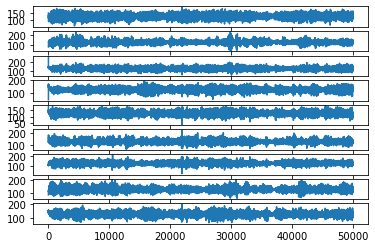

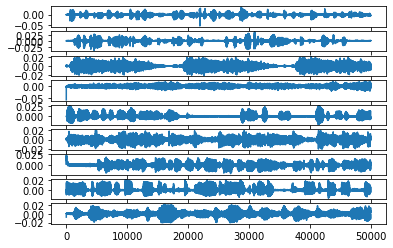

In [1]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to load the audio data
def loadData(dataPath, nsources=9, size=50000, ncomponents=9):
    data = np.empty((nsources, size), np.float32)

    for i in range(9):
        fs, data[i,:] = wavfile.read(os.path.join(dataPath, 'mix') + str(i+1) + '.wav')

    return fs, data

# Function to display the audio spectrum
def displayData(X):
    C = X.shape[0]

    for i in range(C):
        plt.subplot(C, 1, i + 1)
        plt.plot(X[i,:])
    plt.show()

# Function to save the audio data separated by fastica
def saveData(saveDataPath, fs, X):
    for i in range(X.shape[0]):
        wavfile.write(os.path.join(saveDataPath, 'ica_') + str(i + 1) + ".wav", fs, X[i,:])

# Definition of G'
def Gprime(x):
    return np.tanh(x)

# Definition of G''
def Gsecond(x):
    return np.ones(x.shape) - np.power(np.tanh(x), 2)

# Center matrix X
def centerMatrix(X, N):
    mean = X.mean(axis=1)
    M = X - (mean.reshape((N, 1)) @ np.ones((1, X.shape[1])))
    return M

# Whiten matrix X with eigenvalue decomposition
def whitenMatrix(X):
    D, E = np.linalg.eigh(X @ X.T)
    DE = np.diag(1/np.sqrt(D)) @ E.T
    
    return DE @ X

# One-unit algorithm step
def oneUnit(X, wp):
    term1 = np.mean((X @ Gprime(wp @ X).T), axis=1)
    term2 = np.mean(Gsecond(wp @ X), axis=1) * wp
    return term1 - term2

# Deflationary orthogonalization
def orthogonolize(W, wp, i):
    return wp - ((wp @ W[:i,:].T) @ W[:i,:])

# wp normalization
def normalize(wp):
    return wp / np.linalg.norm(wp)

# Function to see if wp is still updating
def diff(wp1, wp2):
    norm1 = np.linalg.norm(wp1)
    norm2 = np.linalg.norm(wp2)
    return np.abs(norm1 - norm2)


def fastICA(X, C):
    N = X.shape[0]
    X = centerMatrix(X, N)
    X = whitenMatrix(X)
    
    W = np.zeros((N, C))
    for i in range(N):
        wp = np.random.rand(1, C)
        while(1):
            old_wp = wp
            wp = oneUnit(X, wp)
            wp = orthogonolize(W, wp, i)
            wp = normalize(wp)
            
            if(diff(old_wp, wp) == 0):
                W[i,:] = wp
                break

    return W @ X


dataPath = ""  # path to the folder containing the mix audio sounds
saveDataPath = ""  # path to the folder that will contain the results of the fastICA

if not os.path.exists(dataPath):
    os.makedirs(dataPath)

if not os.path.exists(saveDataPath):
    os.makedirs(saveDataPath)

fs, X = loadData(dataPath)
displayData(X)

S = fastICA(X, 9)
displayData(S)

saveData(saveDataPath, fs, S)